In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 

import sys
sys.path.append("/home/armstrong/Research/git_repos/seis-proc-dl")
from utils.model_helpers import compute_outer_fence_mean_standard_deviation

In [2]:
pwd

'/home/armstrong/Research/git_repos/patprob/no_duplicates/dropout'

In [3]:
dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
checkpoints = [32, 29, 34]

In [4]:
ls seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint32_dropout0.01_N40/

dropout_NGB_uncertainty_32.npz
dropout_NGB_uncertainty_32_residual_summary_40.csv
dropout_test_fewerhist_uncertainty_32.npz
dropout_test_fewerhist_uncertainty_32_residual_summary_40.csv
dropout_validation_uncertainty_32.npz
dropout_validation_uncertainty_32_residual_summary_40.csv


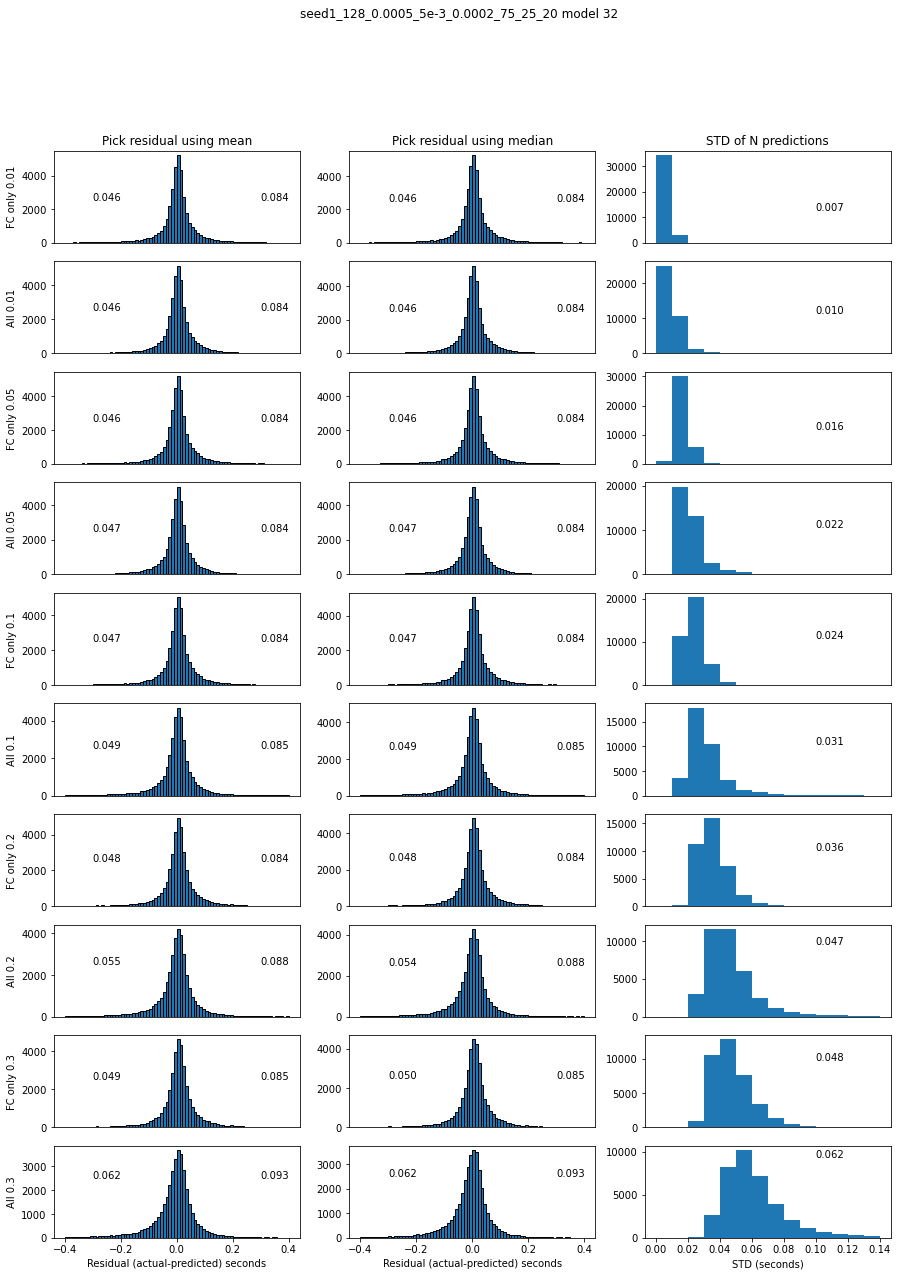

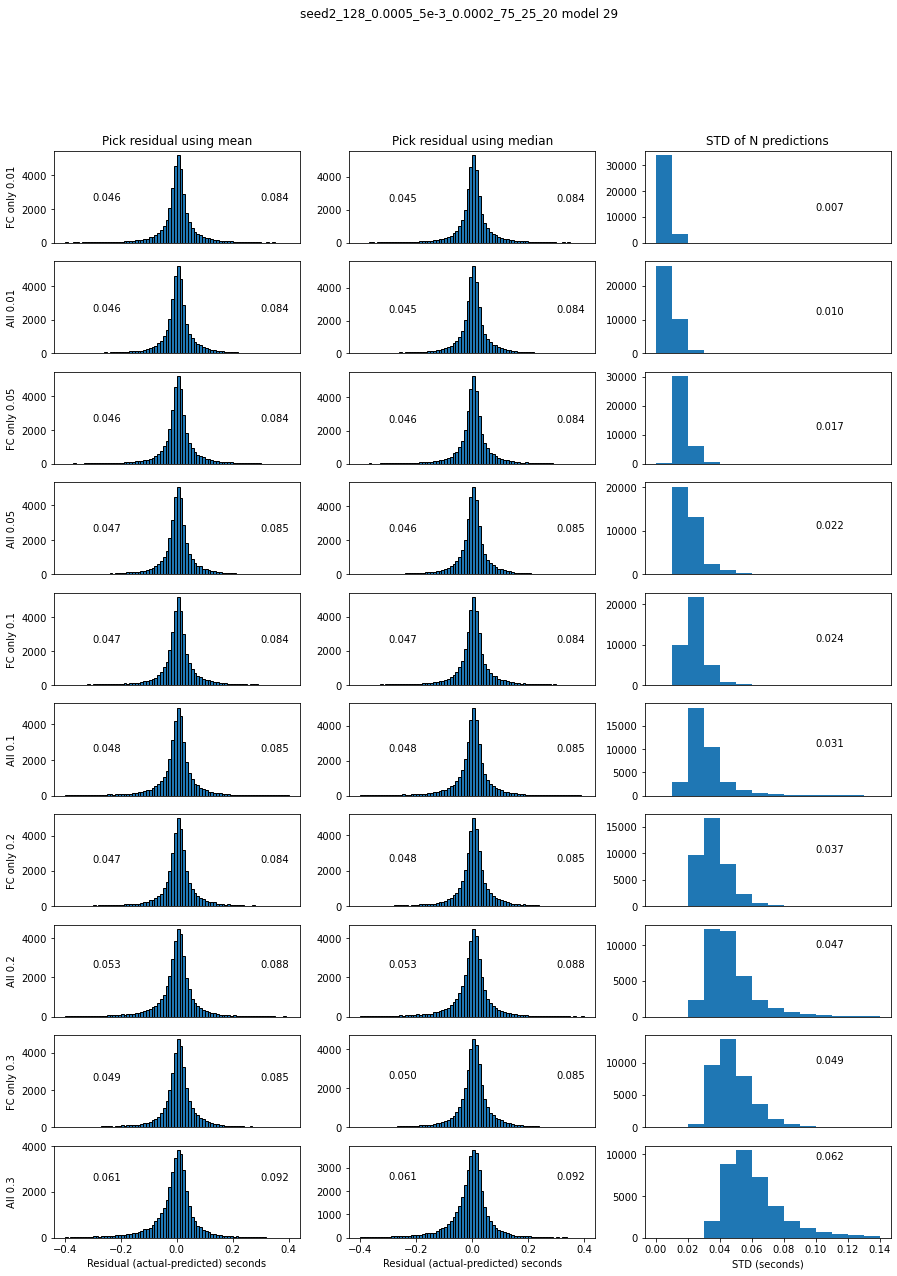

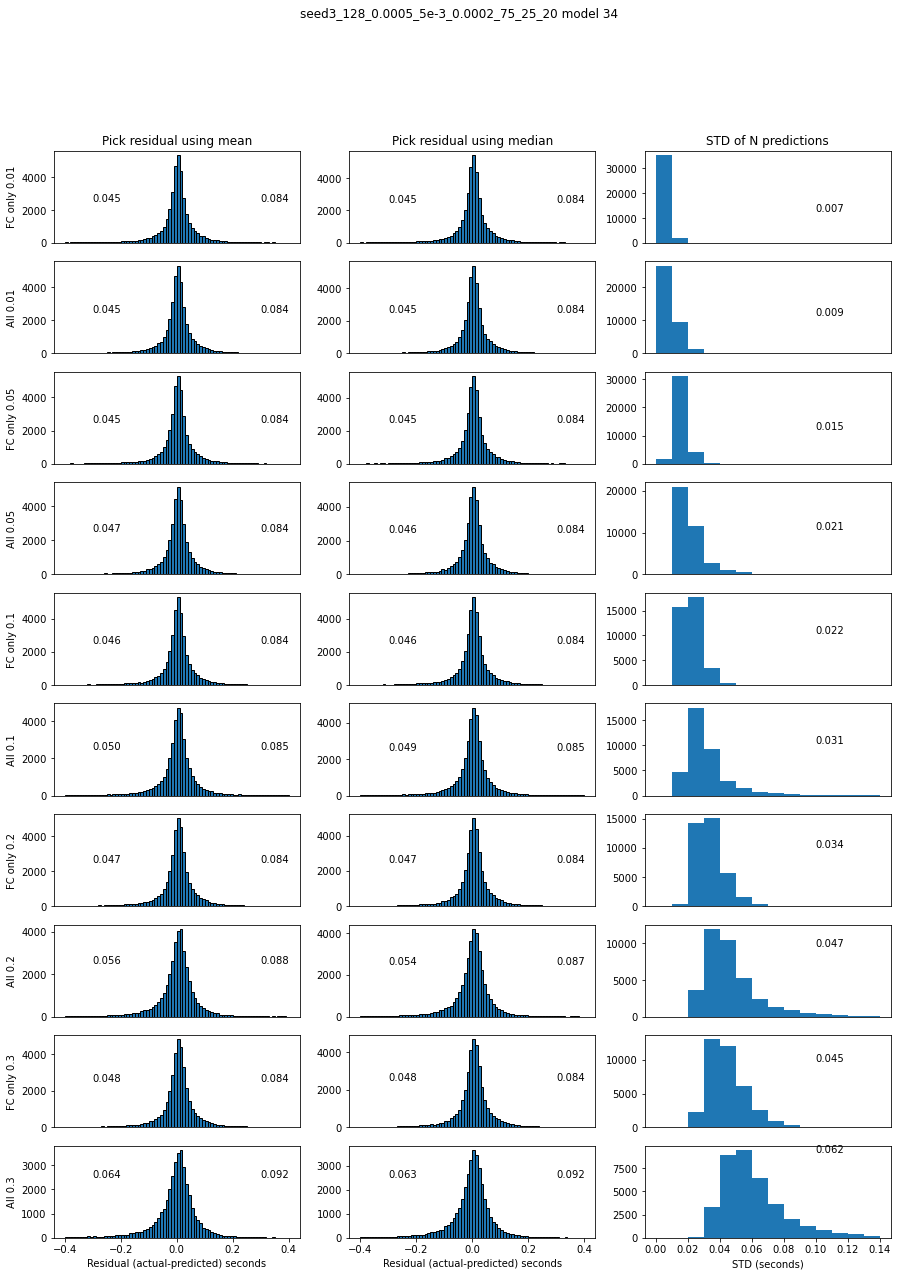

In [5]:
N_rows = 10
for seed in [1, 2, 3]:
    pref = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20"
    cp = checkpoints[seed-1]
    fig, axes = plt.subplots(N_rows, 3, figsize=(15, N_rows*2))
    fig.suptitle(f"{pref} model {cp}")
    i = 0    
    for drate in dropout_rates:
        for cnn_dropout in [0, 1]:
            if cnn_dropout:
                npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_N40/dropout_validation_uncertainty_*.npz")[0])
                pid = f"All {drate}"
            else:
                npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_FConly_N40/dropout_validation_uncertainty_*.npz")[0])
                pid = f"FC only {drate}"

            preds = npz_file["predictions"]
            targets = npz_file["targets"]
            pred_median = np.expand_dims(np.median(preds, axis=1), axis=1)
            pred_mean = np.expand_dims(npz_file["prediction_mean"], axis=1)
            pred_std = npz_file["prediction_std"]
            mean_resids = targets - pred_mean
            median_resids = targets - pred_median

            axes[i][0].hist(mean_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
            ofmean, ofstd = compute_outer_fence_mean_standard_deviation(mean_resids)
            rms = np.sqrt(np.sum(mean_resids**2)/len(mean_resids))
            axes[i][0].text(0.3, 2500, f"{rms:0.3f}")
            axes[i][0].text(-0.3, 2500, f"{ofstd:0.3f}")

            axes[i][1].hist(median_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
            ofmean, ofstd = compute_outer_fence_mean_standard_deviation(median_resids)
            rms = np.sqrt(np.sum(median_resids**2)/len(median_resids))
            axes[i][1].text(0.3, 2500, f"{rms:0.3f}")
            axes[i][1].text(-0.3, 2500, f"{ofstd:0.3f}")

            axes[i][2].hist(pred_std, np.arange(0, 0.15, 0.01));
            axes[i][2].text(0.10, 8000, f"{np.mean(pred_std):0.3f}\n")

            if i < N_rows-1:
                axes[i][0].set_xticks([])
                axes[i][1].set_xticks([])
                axes[i][2].set_xticks([])

            axes[i][0].set_ylabel(pid)

            i+=1


    axes[0][0].set_title("Pick residual using mean");
    axes[-1][0].set_xlabel("Residual (actual-predicted) seconds");
    axes[0][1].set_title("Pick residual using median");
    axes[-1][1].set_xlabel("Residual (actual-predicted) seconds");
    axes[0][2].set_title("STD of N predictions");
    axes[-1][2].set_xlabel("STD (seconds)");

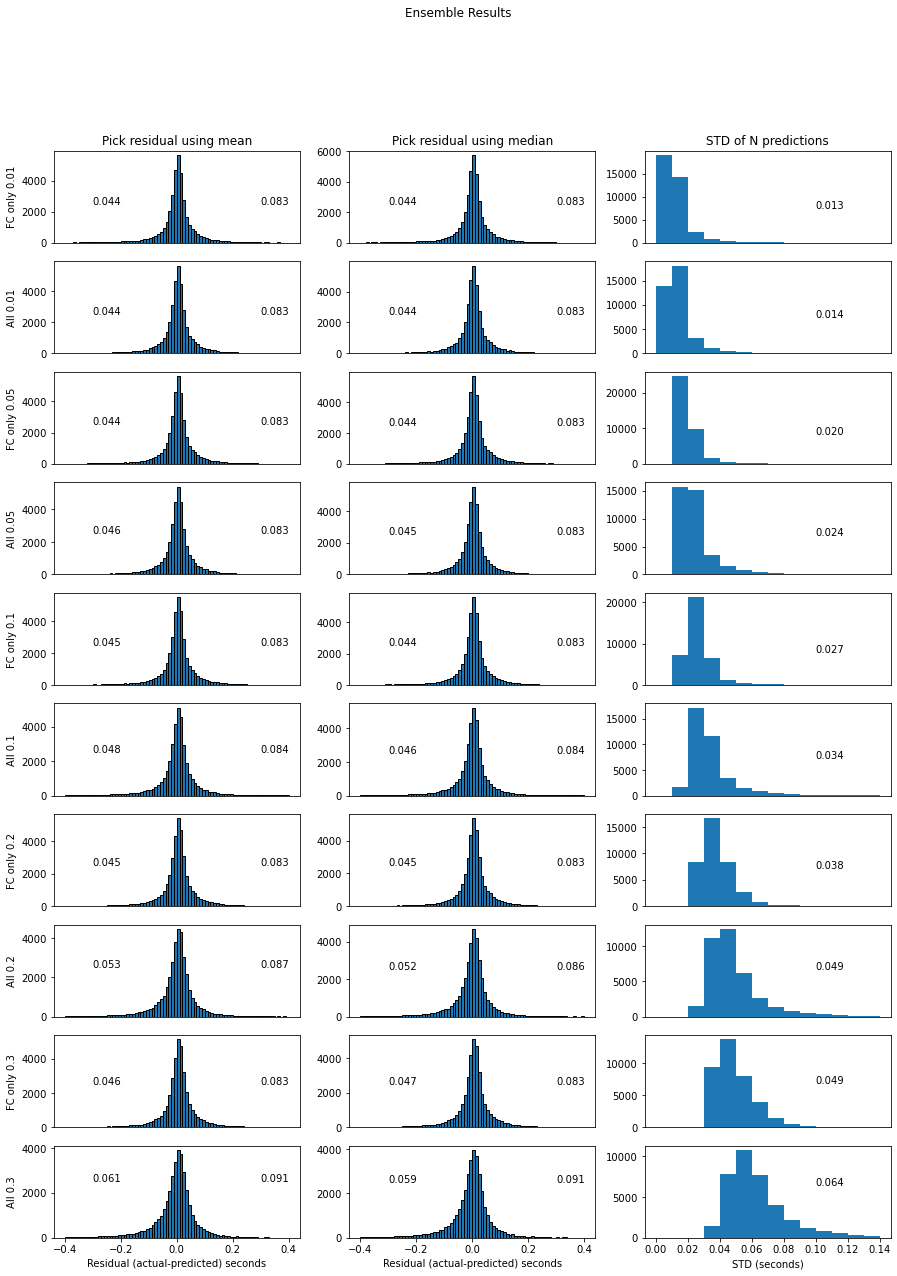

In [6]:
N_rows = 10
fig, axes = plt.subplots(N_rows, 3, figsize=(15, N_rows*2))
fig.suptitle("Ensemble Results")
i = 0    
for drate in dropout_rates:
    for cnn_dropout in [0, 1]:
        ensemble_preds = np.zeros((preds.shape[0], preds.shape[1]*3))
        for seed in [1, 2, 3]:
            pref = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20"
            cp = checkpoints[seed-1]
            
            if cnn_dropout:
                npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_N40/dropout_validation_uncertainty_*.npz")[0])
                pid = f"All {drate}"
            else:
                npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_FConly_N40/dropout_validation_uncertainty_*.npz")[0])
                pid = f"FC only {drate}"

            ensemble_preds[:, (seed-1)*40:seed*40] = npz_file["predictions"]
            
        targets = npz_file["targets"]
        pred_median = np.expand_dims(np.median(ensemble_preds, axis=1), axis=1)
        pred_mean = np.expand_dims(np.mean(ensemble_preds, axis=1), 1)
        pred_std = np.std(ensemble_preds, axis=1)
        mean_resids = targets - pred_mean
        median_resids = targets - pred_median

        axes[i][0].hist(mean_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
        ofmean, ofstd = compute_outer_fence_mean_standard_deviation(mean_resids)
        rms = np.sqrt(np.sum(mean_resids**2)/len(mean_resids))
        axes[i][0].text(-0.3, 2500, f"{ofstd:0.3f}")
        axes[i][0].text(0.3, 2500, f"{rms:0.3f}")


        axes[i][1].hist(median_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
        ofmean, ofstd = compute_outer_fence_mean_standard_deviation(median_resids)
        rms = np.sqrt(np.sum(median_resids**2)/len(mean_resids))
        axes[i][1].text(-0.3, 2500, f"{ofstd:0.3f}")
        axes[i][1].text(0.3, 2500, f"{rms:0.3f}")
        
        axes[i][2].hist(pred_std, np.arange(0, 0.15, 0.01));
        axes[i][2].text(0.10, 5000, f"{np.mean(pred_std):0.3f}\n")

        if i < N_rows-1:
            axes[i][0].set_xticks([])
            axes[i][1].set_xticks([])
            axes[i][2].set_xticks([])

        axes[i][0].set_ylabel(pid)

        i+=1


axes[0][0].set_title("Pick residual using mean");
axes[-1][0].set_xlabel("Residual (actual-predicted) seconds");
axes[0][1].set_title("Pick residual using median");
axes[-1][1].set_xlabel("Residual (actual-predicted) seconds");
axes[0][2].set_title("STD of N predictions");
axes[-1][2].set_xlabel("STD (seconds)");

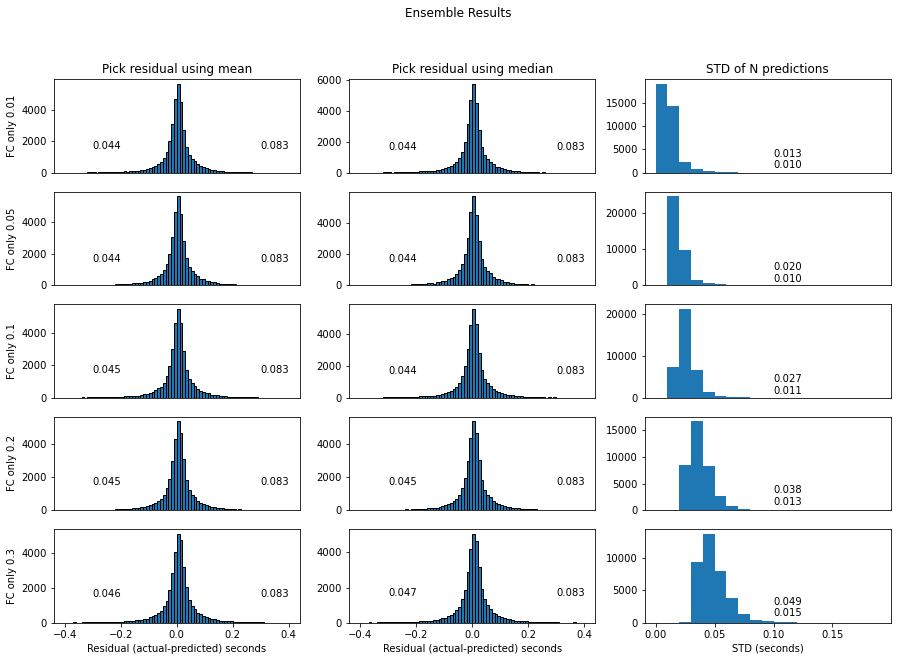

In [7]:
# dropout_rates = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9]
dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
N_rows = len(dropout_rates)
fig, axes = plt.subplots(N_rows, 3, figsize=(15, N_rows*2))
fig.suptitle("Ensemble Results")
i = 0    
for drate in dropout_rates:
    ensemble_preds = np.zeros((preds.shape[0], preds.shape[1]*3))
    for seed in [1, 2, 3]:
        pref = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20"
        cp = checkpoints[seed-1]


        npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_FConly_N40/dropout_validation_uncertainty_*.npz")[0])
        pid = f"FC only {drate}"

        ensemble_preds[:, (seed-1)*40:seed*40] = npz_file["predictions"]

    targets = npz_file["targets"]
    pred_median = np.expand_dims(np.median(ensemble_preds, axis=1), axis=1)
    pred_mean = np.expand_dims(np.mean(ensemble_preds, axis=1), 1)
    pred_std = np.std(ensemble_preds, axis=1)
    mean_resids = targets - pred_mean
    median_resids = targets - pred_median

    axes[i][0].hist(mean_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(mean_resids)
    rms = np.sqrt(np.sum(mean_resids**2)/len(mean_resids))
    axes[i][0].text(-0.3,1500, f"{ofstd:0.3f}")
    axes[i][0].text(0.3, 1500, f"{rms:0.3f}")


    axes[i][1].hist(median_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(median_resids)
    rms = np.sqrt(np.sum(median_resids**2)/len(mean_resids))
    axes[i][1].text(-0.3, 1500, f"{ofstd:0.3f}")
    axes[i][1].text(0.3, 1500, f"{rms:0.3f}")

    axes[i][2].hist(pred_std, np.arange(0, 0.2, 0.01));
    axes[i][2].text(0.10, 1000, f"{np.mean(pred_std):0.3f}\n{np.std(pred_std):0.3f}")

    if i < N_rows-1:
        axes[i][0].set_xticks([])
        axes[i][1].set_xticks([])
        axes[i][2].set_xticks([])

    axes[i][0].set_ylabel(pid)

    i+=1


axes[0][0].set_title("Pick residual using mean");
axes[-1][0].set_xlabel("Residual (actual-predicted) seconds");
axes[0][1].set_title("Pick residual using median");
axes[-1][1].set_xlabel("Residual (actual-predicted) seconds");
axes[0][2].set_title("STD of N predictions");
axes[-1][2].set_xlabel("STD (seconds)");

In [8]:
npz_file = np.load(glob.glob(f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint32_dropout0.01_FConly_N40/dropout_test_fewerhist_uncertainty_*.npz")[0])
preds = npz_file["predictions"]

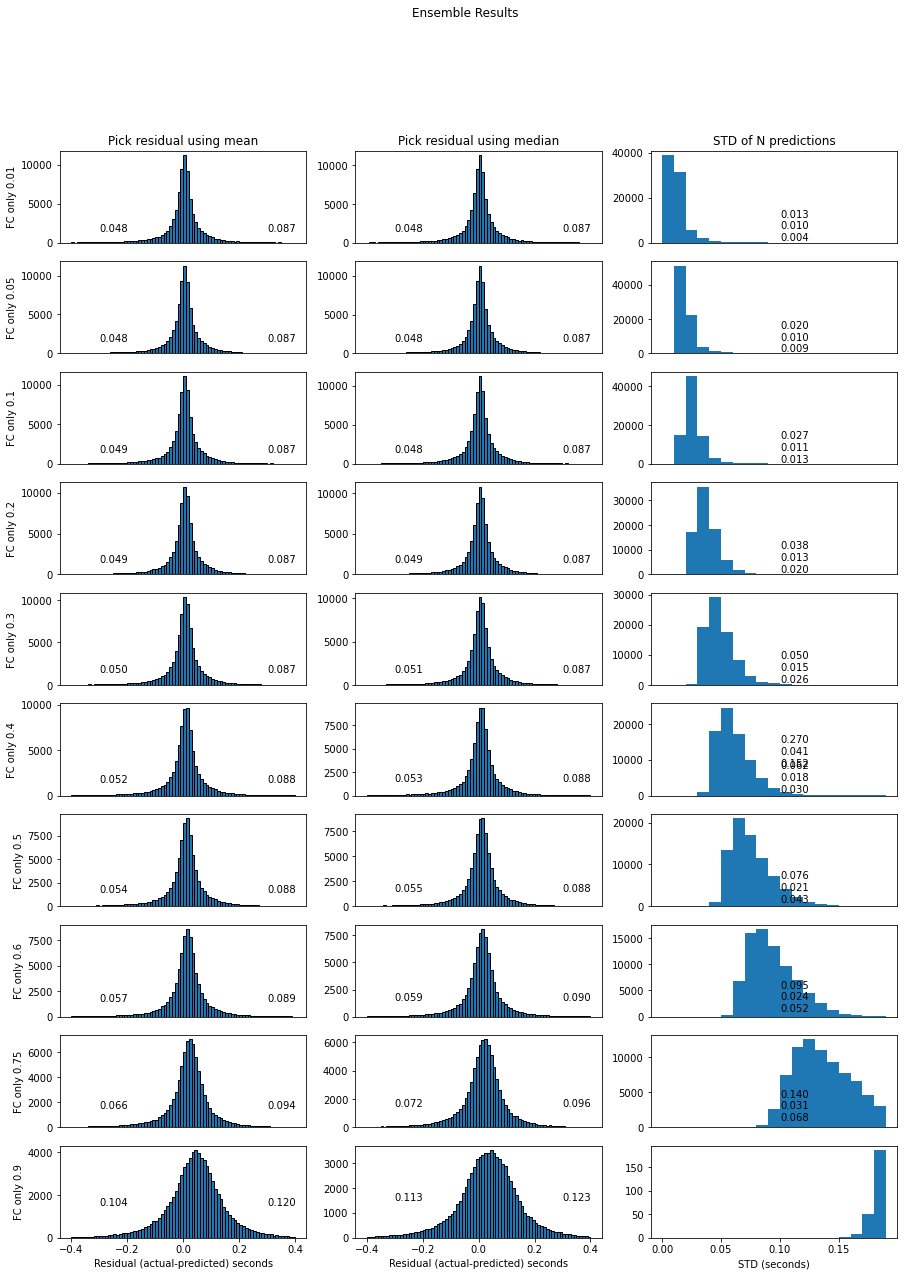

In [14]:
dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9]
#dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3]

N_rows = len(dropout_rates)
fig, axes = plt.subplots(N_rows, 3, figsize=(15, N_rows*2))
fig.suptitle("Ensemble Results")
i = 0    
for drate in dropout_rates:
    ensemble_preds = np.zeros((preds.shape[0], preds.shape[1]*3))
    for seed in [1, 2, 3]:
        pref = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20"
        cp = checkpoints[seed-1]


        npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_FConly_N40/dropout_test_fewerhist_uncertainty_*.npz")[0])
        pid = f"FC only {drate}"

        ensemble_preds[:, (seed-1)*40:seed*40] = npz_file["predictions"]

    targets = npz_file["targets"]
    pred_median = np.expand_dims(np.median(ensemble_preds, axis=1), axis=1)
    pred_mean = np.expand_dims(np.mean(ensemble_preds, axis=1), 1)
    pred_std = np.std(ensemble_preds, axis=1)
    mean_resids = targets - pred_mean
    median_resids = targets - pred_median

    axes[i][0].hist(mean_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(mean_resids)
    rms = np.sqrt(np.sum(mean_resids**2)/len(mean_resids))
    axes[i][0].text(-0.3,1500, f"{ofstd:0.3f}")
    axes[i][0].text(0.3, 1500, f"{rms:0.3f}")


    axes[i][1].hist(median_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(median_resids)
    rms = np.sqrt(np.sum(median_resids**2)/len(mean_resids))
    axes[i][1].text(-0.3, 1500, f"{ofstd:0.3f}")
    axes[i][1].text(0.3, 1500, f"{rms:0.3f}")

    axes[i][2].hist(pred_std, np.arange(0, 0.2, 0.01));
    axes[i][2].text(0.10, 1000, f"{np.mean(pred_std):0.3f}\n{np.std(pred_std):0.3f}\n{np.min(pred_std):0.3f}")

    if i < N_rows-1:
        axes[i][0].set_xticks([])
        axes[i][1].set_xticks([])
        axes[i][2].set_xticks([])

    axes[i][0].set_ylabel(pid)

    i+=1


axes[0][0].set_title("Pick residual using mean");
axes[-1][0].set_xlabel("Residual (actual-predicted) seconds");
axes[0][1].set_title("Pick residual using median");
axes[-1][1].set_xlabel("Residual (actual-predicted) seconds");
axes[0][2].set_title("STD of N predictions");
axes[-1][2].set_xlabel("STD (seconds)");

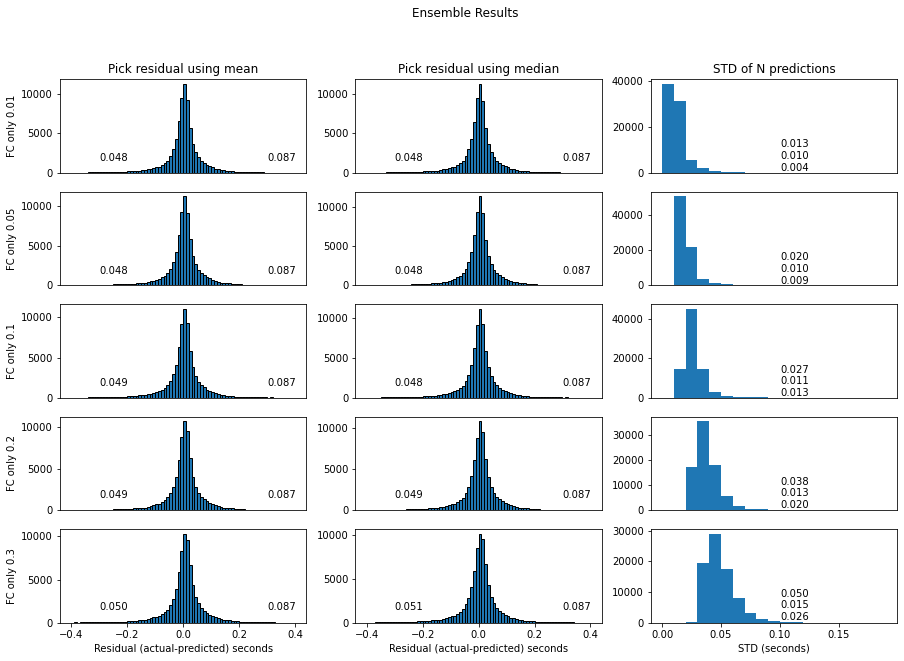

In [12]:
# dropout_rates = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 0.9]
dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3]

N_rows = len(dropout_rates)
fig, axes = plt.subplots(N_rows, 3, figsize=(15, N_rows*2))
fig.suptitle("Ensemble Results")
i = 0    
for drate in dropout_rates:
    ensemble_preds = np.zeros((preds.shape[0], preds.shape[1]*3))
    for seed in [1, 2, 3]:
        pref = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20"
        cp = checkpoints[seed-1]


        npz_file = np.load(glob.glob(f"{pref}/eval_checkpoint{cp}_dropout{drate}_FConly_N40/dropout_test_fewerhist_uncertainty_*.npz")[0])
        pid = f"FC only {drate}"

        ensemble_preds[:, (seed-1)*40:seed*40] = npz_file["predictions"]

    targets = npz_file["targets"]
    pred_median = np.expand_dims(np.median(ensemble_preds, axis=1), axis=1)
    pred_mean = np.expand_dims(np.mean(ensemble_preds, axis=1), 1)
    pred_std = np.std(ensemble_preds, axis=1)
    mean_resids = targets - pred_mean
    median_resids = targets - pred_median

    axes[i][0].hist(mean_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(mean_resids)
    rms = np.sqrt(np.sum(mean_resids**2)/len(mean_resids))
    axes[i][0].text(-0.3,1500, f"{ofstd:0.3f}")
    axes[i][0].text(0.3, 1500, f"{rms:0.3f}")


    axes[i][1].hist(median_resids, bins=np.arange(-0.4, 0.41, 0.01), edgecolor="k");
    ofmean, ofstd = compute_outer_fence_mean_standard_deviation(median_resids)
    rms = np.sqrt(np.sum(median_resids**2)/len(mean_resids))
    axes[i][1].text(-0.3, 1500, f"{ofstd:0.3f}")
    axes[i][1].text(0.3, 1500, f"{rms:0.3f}")

    axes[i][2].hist(pred_std, np.arange(0, 0.2, 0.01));
    axes[i][2].text(0.10, 1000, f"{np.mean(pred_std):0.3f}\n{np.std(pred_std):0.3f}\n{np.min(pred_std):0.3f}")

    if i < N_rows-1:
        axes[i][0].set_xticks([])
        axes[i][1].set_xticks([])
        axes[i][2].set_xticks([])

    axes[i][0].set_ylabel(pid)

    i+=1


axes[0][0].set_title("Pick residual using mean");
axes[-1][0].set_xlabel("Residual (actual-predicted) seconds");
axes[0][1].set_title("Pick residual using median");
axes[-1][1].set_xlabel("Residual (actual-predicted) seconds");
axes[0][2].set_title("STD of N predictions");
axes[-1][2].set_xlabel("STD (seconds)");

In [10]:
# Choose 0.5/0.6 which has similar validation RMS as our models or 0.3, which has similar test OF std??

In [11]:
# Check ensemble works like correctly
pref = f"seed1_128_0.0005_5e-3_0.0002_75_25_20"
cp = checkpoints[0]
npz_file = np.load(f"{pref}/eval_checkpoint{cp}_dropout{drate}_N40/dropout_validation_uncertainty_32.npz")
preds1 = npz_file["predictions"]

pref = f"seed2_128_0.0005_5e-3_0.0002_75_25_20"
cp = checkpoints[1]
npz_file = np.load(f"{pref}/eval_checkpoint{cp}_dropout{drate}_N40/dropout_validation_uncertainty_32.npz")
preds2 = npz_file["predictions"]

pref = f"seed3_128_0.0005_5e-3_0.0002_75_25_20"
cp = checkpoints[2]
npz_file = np.load(f"{pref}/eval_checkpoint{cp}_dropout{drate}_N40/dropout_validation_uncertainty_32.npz")
preds3 = npz_file["predictions"]

print("individual")
print(preds1[0, 0:5])
print(preds2[0, 0:5])
print(preds3[0, 0:5])

print("ensemble")
print(ensemble_preds[0, 0:5])
print(ensemble_preds[0, 40:45])
print(ensemble_preds[0, 80:85])

FileNotFoundError: [Errno 2] No such file or directory: 'seed2_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint29_dropout0.3_N40/dropout_validation_uncertainty_32.npz'

In [ ]:
summary_N = pd.read_csv("seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint32_dropout0.01_N40/dropout_validation_uncertainty_32_residual_summary_40.csv")

In [ ]:
summary_N.head()

In [ ]:
plt.plot(summary_N.ens_rms)
plt.xlabel("N");
plt.ylabel("ENS RMS (mean)");

In [ ]:
plt.plot(summary_N.ens_of_std)
plt.xlabel("N");
plt.ylabel("ENS OF STD (mean)");